In [3]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from collections import Counter
from datetime import datetime, timedelta
from sklearn import metrics
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn import ensemble
import sklearn.metrics
import time
from datetime import datetime

%matplotlib inline                                
#no need to do plt.show()

In [4]:
train = pd.read_csv('./train.csv',parse_dates=['date'])
test = pd.read_csv('./test.csv',parse_dates=['date'],index_col = 0)
print( ' train shape:{}, columns:{} '.format(train.shape,train.columns))
print( ' test shape:{}, columns:{}'.format(test.shape,test.columns))

print(train['date'].head())
print(train.columns)
train.head()

 train shape:(14006, 3), columns:Index(['id', 'date', 'speed'], dtype='object') 
 test shape:(3504, 1), columns:Index(['date'], dtype='object')
0   2017-01-01 00:00:00
1   2017-01-01 01:00:00
2   2017-01-01 02:00:00
3   2017-01-01 03:00:00
4   2017-01-01 04:00:00
Name: date, dtype: datetime64[ns]
Index(['id', 'date', 'speed'], dtype='object')


,id,date,speed
0,0,2017-01-01 00:00:00,43.002930
1,1,2017-01-01 01:00:00,46.118696
2,2,2017-01-01 02:00:00,44.294158
3,3,2017-01-01 03:00:00,41.067468
4,4,2017-01-01 04:00:00,46.448653


In [5]:
# for df in (train,test): 
#     df['hr']    = df['date'].dt.hour
# speed1=train[train.speed>50]
# speed1.to_csv("speed50.csv", index=False)
# speed2=train[train.speed<10]
# speed2.to_csv("speed10.csv", index=False)

# #发现50以上的绝大部分都是0123点  10以下绝大部分是1718点

In [6]:
###处理特征


#date转  年 月 日 时 周几 年内第几周 季节  ：date speed year month day hr weekday weekofyear season dayofyear
for df in (train,test): 
    df['year']  = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day']   = df['date'].dt.day
    df['hr']    = df['date'].dt.hour
    df["weekdayth"] = df['date'].dt.weekday                                  #周几
    df["weekofyear"] = df['date'].dt.isocalendar().week.astype("int")
    df["season"] = df['date'].dt.quarter.fillna(0).astype("int")
    df["dayofyear"] = df['date'].dt.dayofyear
    
    
for df in (train,test):
    df['y/n-weekday'] = np.nan 
    df.loc[(df.weekdayth==5),'y/n-weekday']=1  #周六为1
    df.loc[(df.weekdayth<=4),'y/n-weekday']=0  #工作日为0
    df.loc[(df.weekdayth==6),'y/n-weekday']=2  #周天为2
    
#时 转 白天黑夜早晚高峰      
for df in (train,test):
    df['hr-categori'] = np.nan #创建一个空字段，选择一个内容进行占位，不影响后面数据的插入
    df.loc[(df.weekdayth <= 4)&(df.weekdayth >= 0)&(df.hr <= 9)&(df.hr >= 7), 'hr-categori'] = 3   #工作日的早高峰7-9点
    df.loc[(df.weekdayth <= 4)&(df.weekdayth >= 0)&(df.hr <= 18)&(df.hr >= 16), 'hr-categori'] = 3  #工作日的晚高峰16-18点
    
#     df.loc[(df.weekdayth <= 4)&(df.weekdayth >= 0)&(df.hr >= 0)&(df.hr < 7), 'hr-categori'] = 0
#     df.loc[(df.weekdayth <= 4)&(df.weekdayth >= 0)&(df.hr > 9)&(df.hr < 17), 'hr-categori'] = 1
#     df.loc[(df.weekdayth <= 4)&(df.weekdayth >= 0)&(df.hr >19)&(df.hr <= 24), 'hr-categori'] = 2

    df.loc[(df.weekdayth <= 4)&(df.weekdayth >= 0)&(df.hr > 18)|(df.hr < 7), 'hr-categori'] = 0
    df.loc[(df.weekdayth <= 4)&(df.weekdayth >= 0)&(df.hr > 9)&(df.hr < 16), 'hr-categori'] = 1


    df.loc[(df.weekdayth >= 5)&(df.hr < 19)&(df.hr > 7), 'hr-categori'] = 4                      #周末的白天
    df.loc[(df.weekdayth >= 5)&(df.hr <= 7)|(df.hr >= 19), 'hr-categori'] = 5                    #周末的晚上

    
#加香港2017 2018节假日       ：date speed year month day hr weekday weekofyear season dayofyear hr-categori y/n-holiday
public_vacation_list = [
    '20180101', '20180216','20180217','20180219','20180330','20180331','20180402','20180405',
    '20180501','20180522','20180618','20180702','20180925','20181001','20181017','20181225','20181226',
    '20170102','20170128','20170130','20170131','20170404','20170414','20170415','20170417','20170501',
    '20170503','20170530','20170701','20171002','20171005','20171028','20171225','20171226'
] 
for df in (train,test):
    df['only-ymd'] = df['date'].apply(lambda x: x.strftime('%Y%m%d'))
    df['y/n-holiday'] = df['only-ymd'].apply(lambda x: 1 if x in public_vacation_list else 0)

    
    
df_train = train.drop(columns= ['only-ymd','date','id'], axis= 1).copy()
df_test = test.drop(columns= ['only-ymd','date'], axis= 1).copy()


In [7]:
df_train.corr()['speed']    #查看相关性

speed          1.000000
year           0.015102
month         -0.028827
day           -0.019485
hr            -0.390044
weekdayth      0.115887
weekofyear    -0.026907
season        -0.022967
dayofyear     -0.030255
y/n-weekday    0.171853
hr-categori   -0.049968
y/n-holiday    0.055386
Name: speed, dtype: float64

In [8]:
df_train.head(130)

,speed,year,month,day,hr,weekdayth,weekofyear,season,dayofyear,y/n-weekday,hr-categori,y/n-holiday
0,43.002930,2017,1,1,0,6,52,1,1,2.0,5.0,0
1,46.118696,2017,1,1,1,6,52,1,1,2.0,5.0,0
2,44.294158,2017,1,1,2,6,52,1,1,2.0,5.0,0
3,41.067468,2017,1,1,3,6,52,1,1,2.0,5.0,0
4,46.448653,2017,1,1,4,6,52,1,1,2.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
125,45.732593,2017,6,1,5,3,22,2,152,0.0,0.0,0
126,42.427135,2017,6,1,6,3,22,2,152,0.0,0.0,0
127,23.348662,2017,6,1,7,3,22,2,152,0.0,3.0,0
128,12.192794,2017,6,1,8,3,22,2,152,0.0,3.0,0


In [9]:
df_test.head()

,year,month,day,hr,weekdayth,weekofyear,season,dayofyear,y/n-weekday,hr-categori,y/n-holiday
id,,,,,,,,,,,
0,2018,1,1,2,0,1,1,1,0.0,0.0,1
1,2018,1,1,5,0,1,1,1,0.0,0.0,1
2,2018,1,1,7,0,1,1,1,0.0,3.0,1
3,2018,1,1,8,0,1,1,1,0.0,3.0,1
4,2018,1,1,10,0,1,1,1,0.0,1.0,1


In [15]:
####不需要编码了
from sklearn.model_selection import train_test_split
#留出法划分数据,就按照经典的37分
Train, Valid = train_test_split(df_train, test_size = 0.02)     

In [16]:
X_train = Train.drop(['speed'], axis=1)     #提取训练数据自变量

Y_train = Train["speed"]                    #提取训练数据因变量

X_valid = Valid.drop(['speed'], axis=1)       #提取测试数据自变量

Y_valid = Valid["speed"]                      #提取测试数据因变量


Y_valid = Y_valid.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)
#重新进行索引顺序



#加载模型，放入相关数据
dtrain = xgb.DMatrix(X_train, label=Y_train)    #放入训练数据
dvalid = xgb.DMatrix(X_valid, label=Y_valid)      #放入测试拟合与否的数据

dtest = xgb.DMatrix(df_test)                #放入最终的需要提交的检测数据

In [17]:
xgb_pars = {
    'nthread':            4,  
    'objective':          'reg:squarederror',
    'learning_rate':      0.02,
    'min_child_weight':   0.7,   
    'max_depth':          10,  
    'subsample':          0.87,
    'colsample_bytree':   1,
    'colsample_bylevel':  0.7,
    'verbosity':             0,
    'reg_alpha':          0.1,
    'gamma':              0,
    #'reg_lambda':         0.4,
}

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

model = xgb.train(xgb_pars, dtrain, 1500, watchlist, early_stopping_rounds=10,
      maximize=False, verbose_eval=1)

print('Modeling RMSLE %.5f' % model.best_score)



[0]	train-rmse:34.32655	valid-rmse:34.83846
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:33.66023	valid-rmse:34.15894
[2]	train-rmse:33.00736	valid-rmse:33.49210
[3]	train-rmse:32.36751	valid-rmse:32.83914
[4]	train-rmse:31.74179	valid-rmse:32.19723
[5]	train-rmse:31.12810	valid-rmse:31.56895
[6]	train-rmse:30.53317	valid-rmse:30.96320
[7]	train-rmse:29.94413	valid-rmse:30.36122
[8]	train-rmse:29.36643	valid-rmse:29.77326
[9]	train-rmse:28.80137	valid-rmse:29.19554
[10]	train-rmse:28.24879	valid-rmse:28.63167
[11]	train-rmse:27.70675	valid-rmse:28.07870
[12]	train-rmse:27.17534	valid-rmse:27.53326
[13]	train-rmse:26.65436	valid-rmse:27.00280
[14]	train-rmse:26.14440	valid-rmse:26.48429
[15]	train-rmse:25.64561	valid-rmse:25.97772
[16]	train-rmse:25.15641	valid-rmse:25.48194
[17]	train-rmse:24.67834	valid-rmse:24.99332
[18]	train-rmse:24.21024	valid-rmse:24.51080
[19]	train

[183]	train-rmse:3.86296	valid-rmse:4.29096
[184]	train-rmse:3.84603	valid-rmse:4.28437
[185]	train-rmse:3.83622	valid-rmse:4.27868
[186]	train-rmse:3.82452	valid-rmse:4.27430
[187]	train-rmse:3.80934	valid-rmse:4.26520
[188]	train-rmse:3.79907	valid-rmse:4.26100
[189]	train-rmse:3.79207	valid-rmse:4.25651
[190]	train-rmse:3.78121	valid-rmse:4.24789
[191]	train-rmse:3.77309	valid-rmse:4.24017
[192]	train-rmse:3.76789	valid-rmse:4.23718
[193]	train-rmse:3.75793	valid-rmse:4.23057
[194]	train-rmse:3.74954	valid-rmse:4.22687
[195]	train-rmse:3.73572	valid-rmse:4.22265
[196]	train-rmse:3.72509	valid-rmse:4.21289
[197]	train-rmse:3.71624	valid-rmse:4.20701
[198]	train-rmse:3.70771	valid-rmse:4.20044
[199]	train-rmse:3.69586	valid-rmse:4.19616
[200]	train-rmse:3.68480	valid-rmse:4.18379
[201]	train-rmse:3.67625	valid-rmse:4.17890
[202]	train-rmse:3.66834	valid-rmse:4.17270
[203]	train-rmse:3.66274	valid-rmse:4.17044
[204]	train-rmse:3.64954	valid-rmse:4.16475
[205]	train-rmse:3.63971	valid-r

[370]	train-rmse:2.66764	valid-rmse:3.74341
[371]	train-rmse:2.66559	valid-rmse:3.74221
[372]	train-rmse:2.66131	valid-rmse:3.74147
[373]	train-rmse:2.65775	valid-rmse:3.74198
[374]	train-rmse:2.65360	valid-rmse:3.73875
[375]	train-rmse:2.65163	valid-rmse:3.73841
[376]	train-rmse:2.64809	valid-rmse:3.73784
[377]	train-rmse:2.64454	valid-rmse:3.73177
[378]	train-rmse:2.64362	valid-rmse:3.73154
[379]	train-rmse:2.63906	valid-rmse:3.72993
[380]	train-rmse:2.63460	valid-rmse:3.72911
[381]	train-rmse:2.62927	valid-rmse:3.72297
[382]	train-rmse:2.62671	valid-rmse:3.72234
[383]	train-rmse:2.62511	valid-rmse:3.72154
[384]	train-rmse:2.62211	valid-rmse:3.71838
[385]	train-rmse:2.61924	valid-rmse:3.71757
[386]	train-rmse:2.61826	valid-rmse:3.71742
[387]	train-rmse:2.61467	valid-rmse:3.71574
[388]	train-rmse:2.61355	valid-rmse:3.71570
[389]	train-rmse:2.60861	valid-rmse:3.71593
[390]	train-rmse:2.60365	valid-rmse:3.71291
[391]	train-rmse:2.59993	valid-rmse:3.71153
[392]	train-rmse:2.59523	valid-r

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

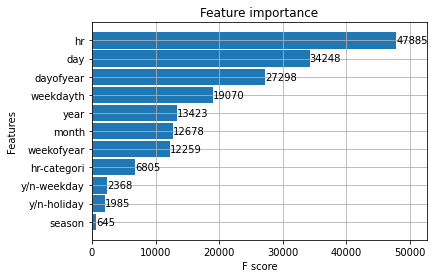

In [18]:
fscores = model.get_fscore()
#top_50_list = sorted(fscores, key=fscores.get, reverse=True)[:50]
#比如获得前50个特征的排序

xgb.plot_importance(model, max_num_features=20, height=0.9)
#前30特征值绘制条状图

In [19]:
pred = model.predict(dtest)
result = pd.DataFrame({"id":range(3504), "speed":pred})
result.to_csv("submission11.csv", index=False)